In [1]:
import numpy as np
import pandas as pd
import re
import datetime
import math
from matplotlib import pyplot as plt

In [3]:
df = pd.read_csv('project10_data.csv')

# Initialize the max

# First to clean the table with only the time series data
col_list = []
for col in df.columns:
    if re.search("^[0-9]+", col):
        col_list.append(col)

# df_clean symbolizing all dates with given data
df_clean = df[col_list]
df_clean.columns = pd.to_datetime(df_clean.columns, format="%m/%d/%y")
df_clean
# df_clean

# find t0 as the starting time for the simulation
for i in range(len(df_clean.columns)):
    if df_clean.iloc[0, i] >= 5:
        t0 = i
        break
    
print(t0)
print(df_clean.columns[i].date())

45
2020-03-07


# Exercise 2
## Question (1)
Create the rates of active infection $I(t)$ using a difference formula: $I(t) = v(t + t_0 + τ) −v(t + t_0 − τ)$, for $0 ≤ t ≤ T_{max}$. The parameter τ is related to incubation and infection period. Set $τ = 7$ days for now (the assumption is that the infection lasts up to 14 days). Plot $I = I(t)$, the rates of active infection.

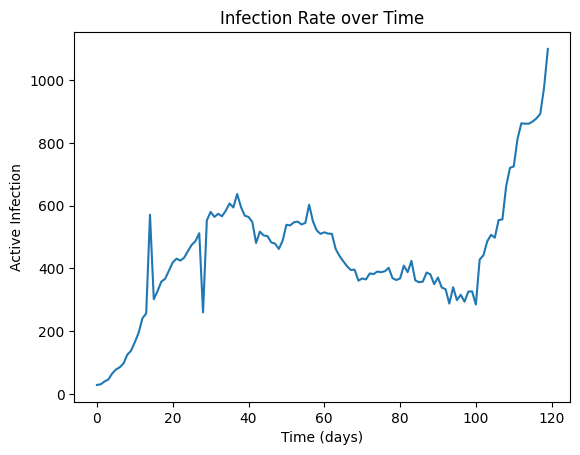

In [12]:
# Get population
population = df["Population"][0]
accumulated_cases = np.array(df_clean.iloc[0])

T_max = 119
I = np.zeros(T_max + 1)

for t in range(0, T_max + 1):
    I[t] = accumulated_cases[t + t0 + 7] - accumulated_cases[t + t0 -7]


plt.figure()
plt.plot(I)
plt.xlabel("Time (days)")
plt.ylabel("Active Infection")
plt.title("Infection Rate over Time")
plt.show()

## Question (2)
Implement an Euler scheme for solving the SIR Model with step size h = 0.01. Denote by $(S_{sim}(t),I_{sim}(t),R_{sim}(t))$ the numerical solution. Use initialization S(0) = N, I(0) from the data set, $R(0) = 0$. For this problem, the unknown parameters are $α,β,N$.

Least squares: S0 = 533.976179674084, beta = 0.04089660124043193, alpha = 0.20000000000000065


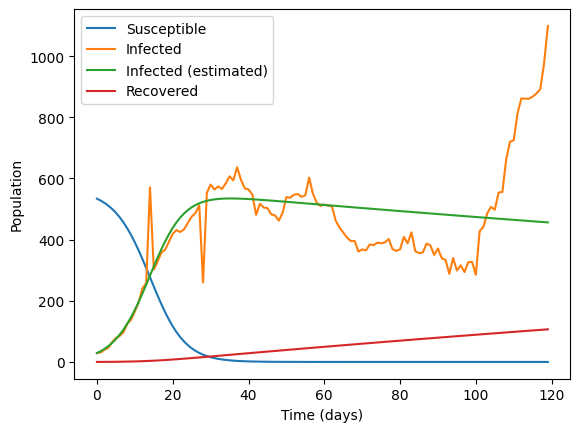

In [16]:
from functools import partial
from scipy.optimize import least_squares

def SIR_simulation(S0, I0, R0, beta, alpha, T0, T_max):
    transition_matrix = lambda p: np.array(
        [
            [np.exp(-beta * T0 * I0), 0, 0],
            [
                beta * I0 / (alpha - beta * I0) * np.exp(-beta * T0 * I0) - 
                beta * I0 / (alpha - beta * I0) * np.exp(-alpha * T0),
                np.exp(-alpha * T0),
                0
            ],
            [
                1 - alpha / (alpha - beta * I0) * np.exp(-beta * T0 * I0) +
                beta * I0 / (alpha - beta * I0) * np.exp(-alpha * T0),
                1 - np.exp(-alpha * T0),
                1
            ]
        ]
    )

    def euler_step(S, I, R, transition_matrix):
        return np.matmul(transition_matrix, np.array([S, I, R]))

    results = [
        [S0, I0, R0]
    ]

    for t in range(1, T_max + 1):
        S0, I0, R0 = euler_step(S0, I0, R0, transition_matrix(t))
        results.append([S0, I0, R0])

    S = np.array([result[0] for result in results])
    I = np.array([result[1] for result in results])
    R = np.array([result[2] for result in results])

    return S, I, R

def SIR_func(x):
    # h = 0.01
    R0 = 0
    I0 = I[0]
    T0 = 0.01

    S0 = x[0]
    beta = x[1]
    alpha = x[2]
    
    _, I_hat, _ = SIR_simulation(S0, I0, R0, beta, alpha, T0, T_max)

    return I - I_hat

# Least squares
minimum_population = 0 #accumulated_cases[T_max + t0]
x0 = np.array([minimum_population, 1, 1])
bounds = ([minimum_population, 0, 0.2], [population, 10, 1])
res = least_squares(SIR_func, x0, bounds=bounds)
# print(res)

S, I_hat, R = SIR_simulation(res.x[0], I[0], 0, res.x[1], res.x[2], 0.01, T_max)
print(f"Least squares: S0 = {res.x[0]}, beta = {res.x[1]}, alpha = {res.x[2]}")

plt.figure()
plt.plot(S, label="Susceptible")
plt.plot(I, label="Infected")
plt.plot(I_hat, label="Infected (estimated)")
plt.plot(R, label="Recovered")
plt.xlabel("Time (days)")
plt.ylabel("Population")
plt.legend()
plt.savefig("SIR.png")

In the above problem, it's necesaary for us to restrict the domain of the variables, otherwise we will get a negative recover rate (which is not realistic).

## Question (3)
For each combination $(α,β,N)$ in the set Ω described below repeat: 

So let's calculate all possible Ω first.

In [18]:
omegas = []

for alpha in [
    1/10, 1/9, 1/8, 1/7, 1/6, 1/5
]:
    for R0 in [
        0.8, 0.9, 0.95, 1, 1.05, 1.1, 1.15, 1.2, 1.3, 1.4, 1.5, 1.6
    ]:
        for N in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]:
            N_max = population * N

            omegas.append((alpha, R0 * alpha, N_max))

assert len(omegas) == 6 * 12 * 10
print(f"Number of combinations: {len(omegas)}")

Number of combinations: 720


### Subquestion (a)
Run your numerical solver and produce $I_{sim}= (I_{sim}(t))$.

In [36]:
I_hats = []
for alpha, beta, N_max in omegas:
    S, I_hat, R = SIR_simulation(N_max, I[0], 0, beta, alpha, 0.01, T_max)
    I_hats.append(I_hat)

omegas = np.array(omegas)
I_hats = np.array(I_hats)

print(f"Finished emulating {len(Js)} combinations")

Finished emulating 720 combinations


### Subquestion (b)
Compute the $l^2$-norm squared of the residuals and save it in an array indexed by the three parameters:

In [38]:
I_err_norms = np.linalg.norm(I_hats - I, axis=1, ord=2)

print(f"Minimum error: {np.min(I_err_norms)}, at index {omegas[np.argmin(I_err_norms)]}")
print(f"Maximum error: {np.max(I_err_norms)}, at index {omegas[np.argmax(I_err_norms)]}")

Minimum error: 849545.0175107017, at index [2.00000e-01 3.20000e-01 8.81549e+04]
Maximum error: 9029226.859714013, at index [1.00000e-01 8.00000e-02 8.81549e+05]


## Question (4)
Visualize the function J by plotting two-dimensional surfaces $(β,N) → J(α,β,N)$ for each value of $α$. In particular determine where the minimum of this function occurs (over the finite set of values considered above).

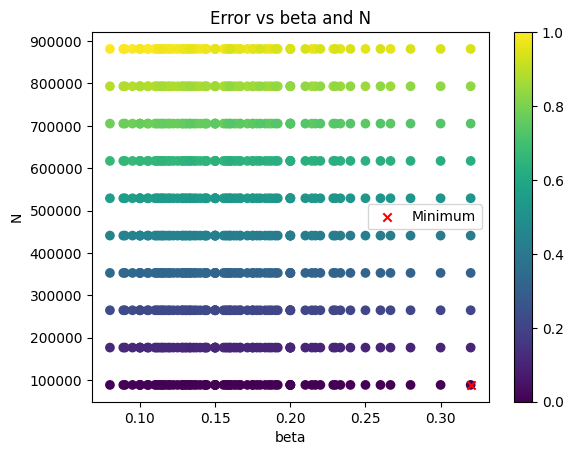

In [40]:
plt.figure()
plt.scatter(omegas[:, 1], omegas[:, 2], c=I_err_norms)
# ax = plt.axes(projection="3d")
# ax.scatter3D(omegas[:, 1], omegas[:, 2], I_err_norms, c=I_err_norms)
# Also plot the minimum
min_J = np.argmin(I_err_norms)
plt.scatter(omegas[min_J, 1], omegas[min_J, 2], c="red", marker="x", label="Minimum")

plt.xlabel("beta")
plt.ylabel("N")
plt.title("Error vs beta and N")
plt.colorbar()
plt.legend()
plt.show()
